## Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import torch
from torch import nn
from torch.utils.data import DataLoader, Subset

In [12]:
import sys
sys.path.append('..')

from src.generators import TransformerGenerator
from src.training import train
from src.plotting import plot_setups, plot_setup_generation
from src.evaluation import plot_per_square_distr_comparison, compute_nearest_neighbors
from src.evaluation import LSTMClassifier, create_classification_dataset, binary_log_loss_from_logits
from src.evaluation import compute_kl_div_single_squares, compute_kl_div_square_pairs

## Load model and sample setups

In [4]:
MODEL_PATH = "../models/transformer_generator.pth"
DATA_PATH = "../data/setups.csv"
SEED = 42

In [6]:
real_setups_df = pd.read_csv(DATA_PATH, header=None, dtype='uint8').drop_duplicates().reset_index(drop=True)
real_setups = real_setups_df.to_numpy()

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model_info = torch.load(MODEL_PATH, map_location=device)
model = TransformerGenerator(**loaded_model_info['model_params'])
model.load_state_dict(loaded_model_info['model_state_dict'])
model = model.to(device)

In [9]:
generated_setups, distributions = model.generate_setups(num_setups=len(real_setups), seed=SEED)
generated_setups_df = pd.DataFrame(generated_setups)

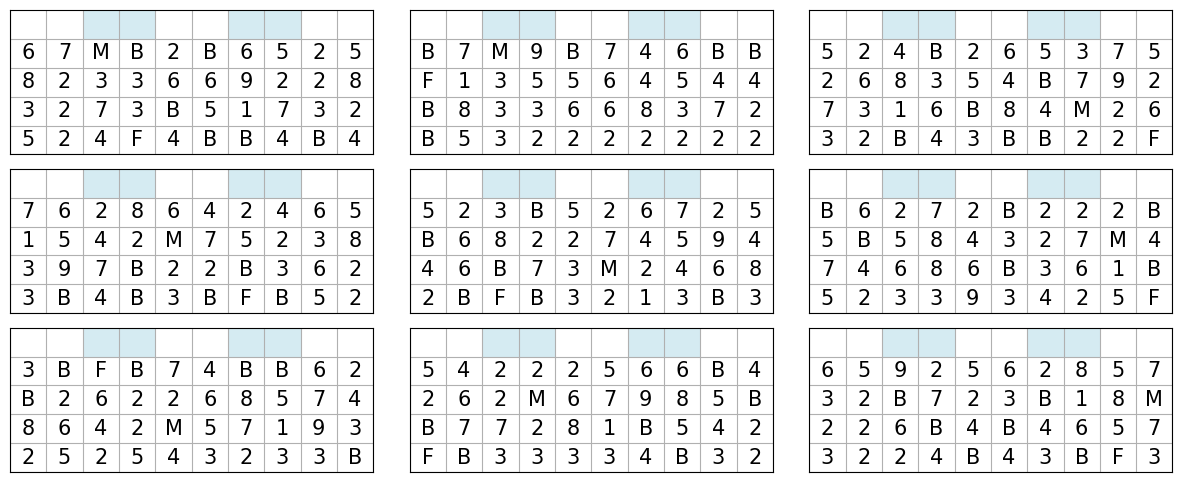

In [ ]:
plot_setups(generated_setups[:9], num_columns=3, tile_size=0.5)

## Compare piece distributions for each square between generated and real setups

We use KL divergence to compare the piece distributions for each square between real and generated setups.
We also compare distributions for each pair of squares.

In [13]:
kl_div_single_squares = compute_kl_div_single_squares(real_setups_df, generated_setups_df)
kl_div_square_pairs = compute_kl_div_square_pairs(real_setups_df, generated_setups_df)

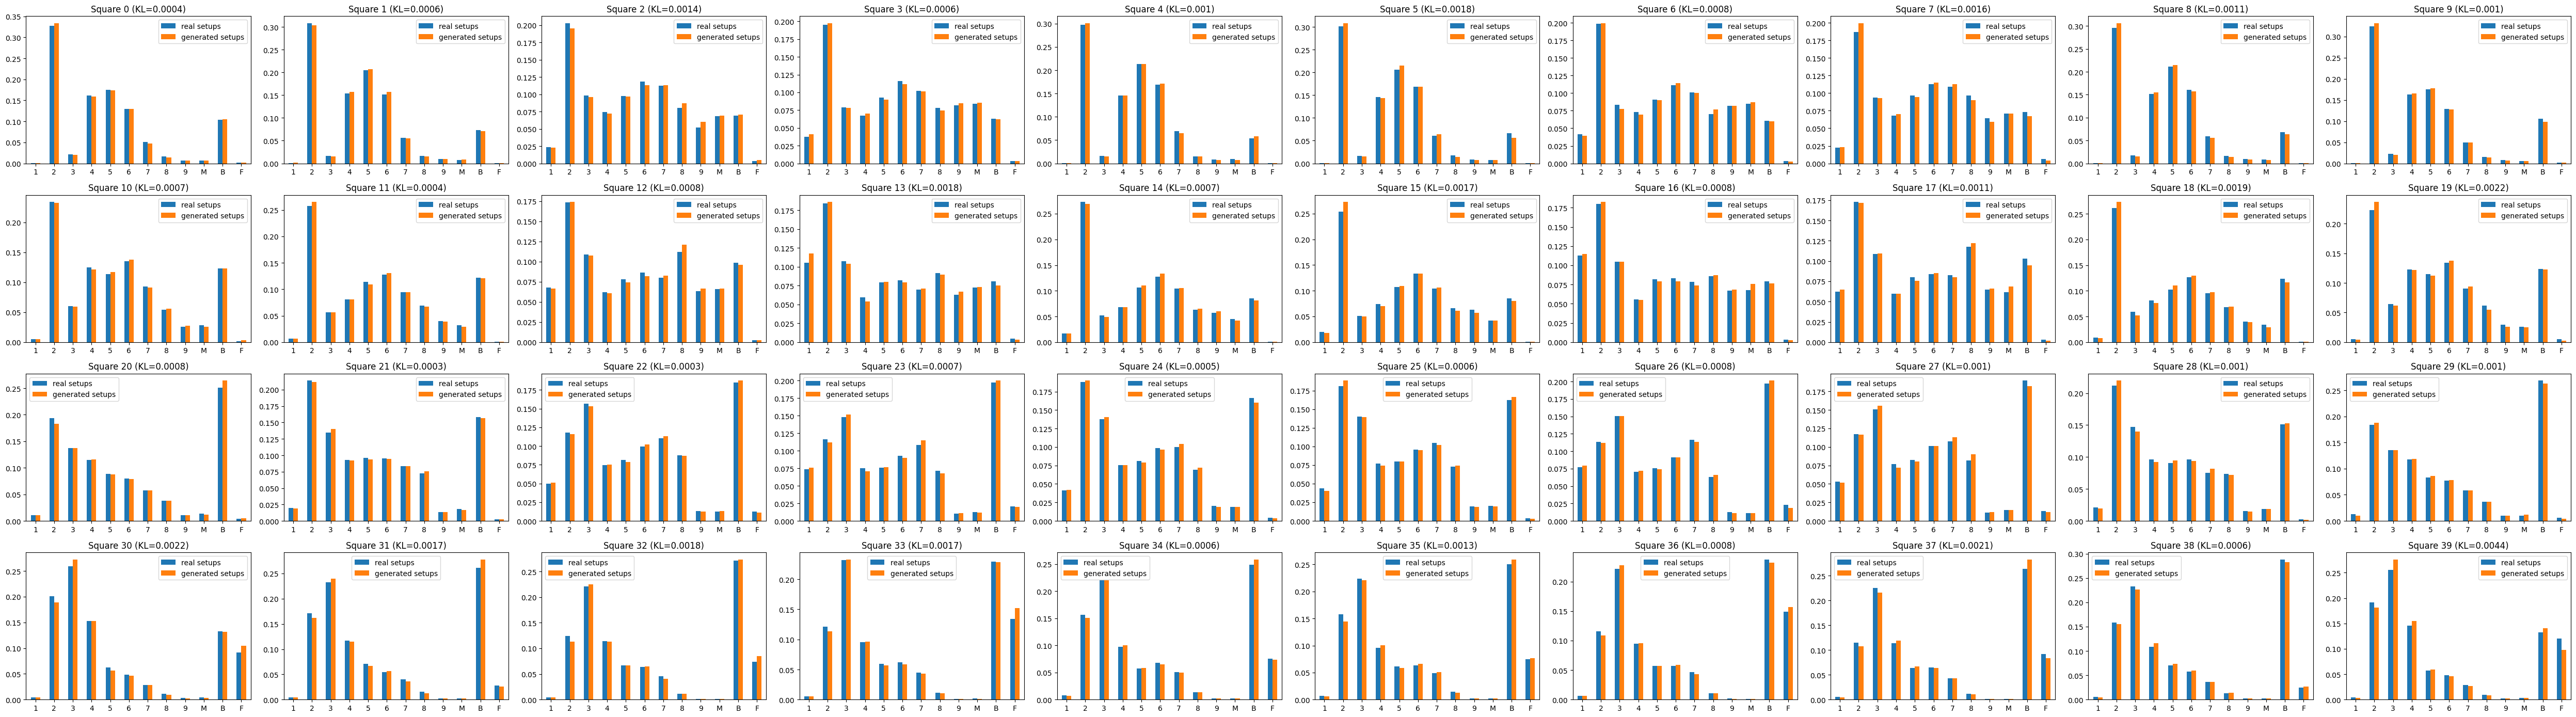

In [14]:
plot_per_square_distr_comparison(real_setups_df, generated_setups_df, kl_div_single_squares)

In [15]:
print(f"Mean KL between piece distributions of real and "
      f"generated setups for each square: {round(kl_div_single_squares.mean(), 5)}")
print(f"Mean KL between piece distributions of real and "
      f"generated setups for each pair of squares: {round(kl_div_square_pairs.mean(), 5)}")

Mean KL between piece distributions of real and generated setups for each square: 0.00116
Mean KL between piece distributions of real and generated setups for each pair of squares: 0.00707


## Compute the most similar real setup for each generated setup

For each generated setup we compute the most similar real setup and the number of piece overlaps with that setup, making sure that our model is not memorizing setups.

In [ ]:
nearest_neighbors, max_overlaps = compute_nearest_neighbors(generated_setups, real_setups)

<BarContainer object of 41 artists>

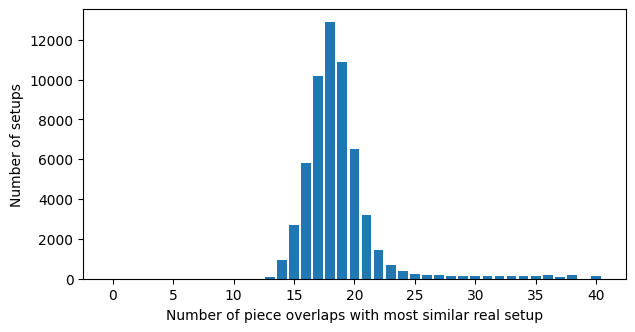

In [ ]:
plt.figure(figsize=(7, 3.5))
plt.xlabel("Number of piece overlaps with most similar real setup")
plt.ylabel("Number of setups")
plt.bar(range(41), [sum(max_overlaps == n) for n in range(41)])

## Adversarial validation

We train a classifier to distinguish between real and generated setups. AUC scores near 0.5 indicate that the distribution of generated setups closely matches the distribution of the real setups.

In [ ]:
real_setups_df['label'] = 1
generated_setups_df['label'] = 0
classification_df = pd.concat([generated_setups_df, real_setups_df])
X = classification_df.drop(columns='label')
y = classification_df['label']

In [ ]:
classification_dataset = create_classification_dataset(X, y)

In [ ]:
criterion =  nn.BCEWithLogitsLoss()
num_epochs = 30
batch_size = 128

classifier_params = {"hidden_size": 256, "embedding_dim": 16, "num_layers": 2}

num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)

In [ ]:
torch.manual_seed(SEED)

training_history = []

for fold_number, (train_indices, val_indices) in enumerate(kfold.split(X, y)):

    print(f"fold {fold_number + 1}")

    classifier = LSTMClassifier(**classifier_params)
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

    train_dataloader = DataLoader(Subset(classification_dataset, train_indices), batch_size=batch_size, shuffle=True,
                                  generator=torch.Generator().manual_seed(SEED))
    val_dataloader = DataLoader(Subset(classification_dataset, val_indices), batch_size=batch_size, shuffle=False)

    metrics_per_epoch = train(classifier, train_dataloader, num_epochs, optimizer, criterion,
                              val_dataloader, eval_metrics=[("Cross Entropy", binary_log_loss_from_logits), ("AUC", roc_auc_score)], )

    training_history.append(metrics_per_epoch)

fold 1
Using device 'cuda'
Epoch: 1, Train Cross Entropy: 0.69111, Train AUC: 0.53637, Val Cross Entropy: 0.69122, Val AUC: 0.53347
Epoch: 2, Train Cross Entropy: 0.68991, Train AUC: 0.54945, Val Cross Entropy: 0.69096, Val AUC: 0.54163
Epoch: 3, Train Cross Entropy: 0.68611, Train AUC: 0.56824, Val Cross Entropy: 0.68859, Val AUC: 0.54991
Epoch: 4, Train Cross Entropy: 0.68343, Train AUC: 0.5833, Val Cross Entropy: 0.68976, Val AUC: 0.56056
Epoch: 5, Train Cross Entropy: 0.6756, Train AUC: 0.60213, Val Cross Entropy: 0.68627, Val AUC: 0.56727
Epoch: 6, Train Cross Entropy: 0.66294, Train AUC: 0.63436, Val Cross Entropy: 0.68401, Val AUC: 0.57725
Epoch: 7, Train Cross Entropy: 0.64719, Train AUC: 0.67314, Val Cross Entropy: 0.68374, Val AUC: 0.58186
Epoch: 8, Train Cross Entropy: 0.61418, Train AUC: 0.72638, Val Cross Entropy: 0.68665, Val AUC: 0.59145
Epoch: 9, Train Cross Entropy: 0.5604, Train AUC: 0.79232, Val Cross Entropy: 0.69499, Val AUC: 0.6078
Epoch: 10, Train Cross Entropy: 

In [ ]:
for i, fold_history in enumerate(training_history, start=1):
    max_score = max(fold_history['val_metrics']['AUC'])
    print(f"Max ROC AUC achieved for fold {i} after {num_epochs} epochs: {round(max_score, 4)}")

Max ROC AUC achieved for fold 1 after 30 epochs: 0.6164
Max ROC AUC achieved for fold 2 after 30 epochs: 0.6185
Max ROC AUC achieved for fold 3 after 30 epochs: 0.6192
Max ROC AUC achieved for fold 4 after 30 epochs: 0.596
Max ROC AUC achieved for fold 5 after 30 epochs: 0.5997


## Piece by piece setup generation

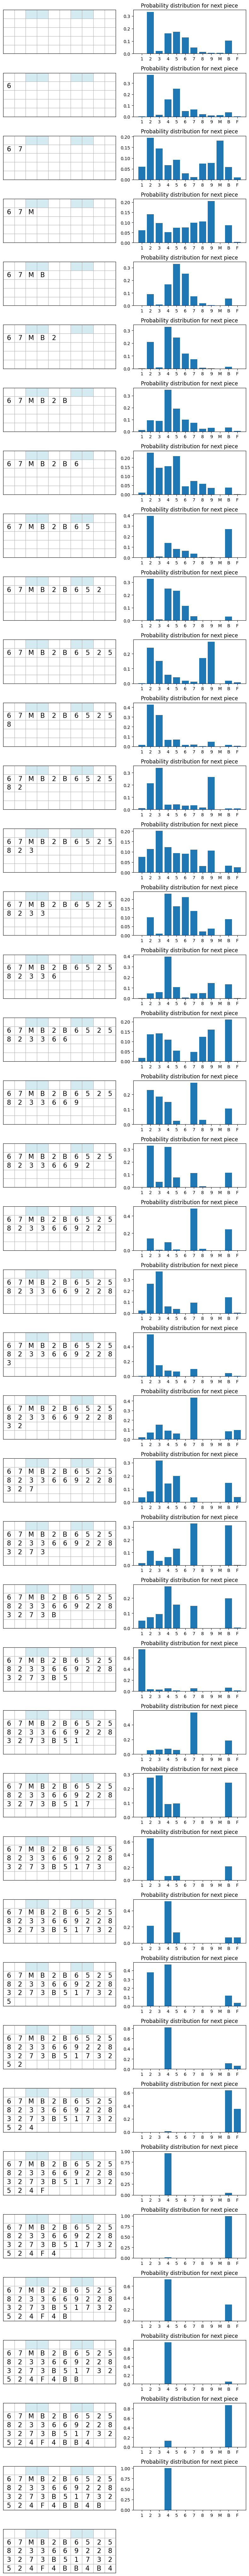

In [ ]:
setup_index = 0
plot_setup_generation(generated_setups[setup_index], distributions[setup_index])